# DEMO 3

Applying an RL model to a dataset.

In [22]:
import sys
import os

# Manually set the path relative to the py file's location that you want to import
func_lib_path = os.path.abspath(os.path.join(os.getcwd(), '../'))# Add the path to sys.path
sys.path.append(func_lib_path)

# Now you can import func_lib
import func_lib
import random
import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import DQN
from gymnasium import spaces
import matplotlib.pyplot as plt

In [23]:
# Generate the training dataset
np.random.seed(42)
days = 100
milk_consumption = np.random.uniform(0, 10, size=days)  # Random milk consumption between 0 and 10 ounces
discomfort = (milk_consumption > 5).astype(int)  # Discomfort turns to 1 if consumption > 5 ounces

# Create a DataFrame for the training dataset
data = pd.DataFrame({
    'day': range(1, days + 1),
    'milk_consumption': milk_consumption,
    'discomfort': discomfort
})

# Generate the testing dataset
np.random.seed(24)
days_test = 50
milk_consumption_test = np.random.uniform(0, 10, size=days_test)  # Random milk consumption between 0 and 10 ounces
discomfort_test = (milk_consumption_test > 5).astype(int)  # Discomfort turns to 1 if consumption > 5 ounces



# Create a DataFrame for the testing dataset
data_test = pd.DataFrame({
    'day': range(1, days_test + 1),
    'milk_consumption': milk_consumption_test,
    'discomfort': discomfort_test
})

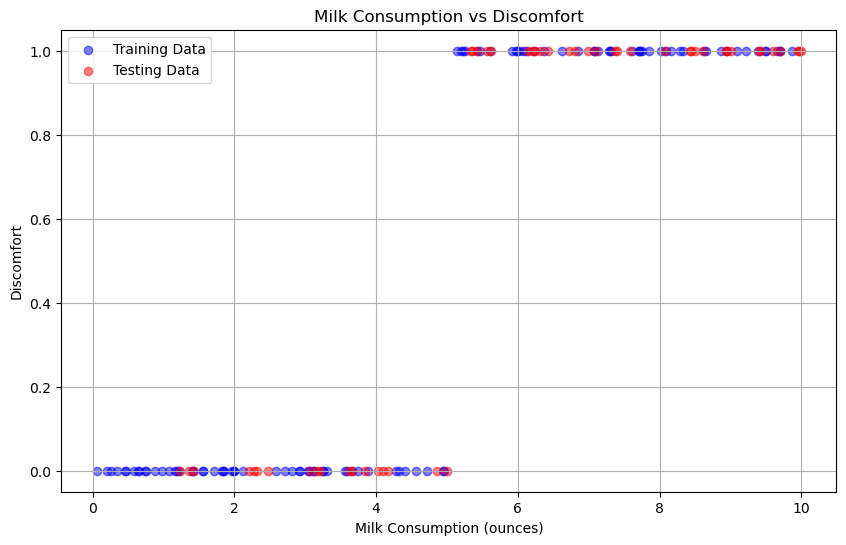

In [24]:
# Plotting the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(data['milk_consumption'], data['discomfort'], color='blue', label='Training Data', alpha=0.5)
plt.scatter(data_test['milk_consumption'], data_test['discomfort'], color='red', label='Testing Data', alpha=0.5)
plt.xlabel('Milk Consumption (ounces)')
plt.ylabel('Discomfort')
plt.title('Milk Consumption vs Discomfort')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Define the custom environment for milk consumption
class MilkConsumptionEnv(gym.Env):
    
    def __init__(self, data):
        super(MilkConsumptionEnv, self).__init__()
        self.data = data
        self.current_day = 0
        self.action_space = spaces.Discrete(2)  # 0: consume less milk, 1: consume more milk
        self.observation_space = spaces.Box(low=0, high=10, shape=(1,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_day = 0
        obs = np.array([self.data.iloc[self.current_day]['milk_consumption']], dtype=np.float32)
        return obs, {}

    def step(self, action):
        self.current_day += 1
        
        if action == 0:  # consume less milk
            next_obs = max(0, self.data.iloc[self.current_day]['milk_consumption'] - 1)
        else:  # consume more milk
            next_obs = min(10, self.data.iloc[self.current_day]['milk_consumption'] + 1)
        
        next_obs = np.array([next_obs], dtype=np.float32)
        done = self.current_day >= len(self.data) - 1
        
        # Reward is -1 if discomfort (1), 0 otherwiseS
        reward = -1 if self.data.iloc[self.current_day]['discomfort'] == 1 else 0
        
        return next_obs, reward, done, False, {}

    def render(self):
        pass
    
    def close(self):
        pass

In [27]:
# Initialize the environment with the training dataset
env = MilkConsumptionEnv(data)

# Create the agent using DQN
agent = DQN('MlpPolicy', env, verbose=0)

# Train the agent
agent.learn(total_timesteps=10000)

In [28]:
# Initialize the testing environment with the new dataset
env_test = MilkConsumptionEnv(data_test)

# Variables to keep track of correct predictions
correct_predictions = 0
total_predictions = 0

# Test the trained agent on the new dataset
obs, _ = env_test.reset()
done = False

while not done:
    action, _ = agent.predict(obs)
    obs, reward, done, _, _ = env_test.step(action)
    
    # The agent's action is based on whether it predicts discomfort or not
    predicted_discomfort = 1 if obs[0] > 5 else 0
    
    # Compare prediction with actual discomfort
    actual_discomfort = env_test.data.iloc[env_test.current_day - 1]['discomfort']
    if predicted_discomfort == actual_discomfort:
        correct_predictions += 1
    total_predictions += 1

# Calculate prediction accuracy
accuracy = correct_predictions / total_predictions * 100
print(f"Prediction accuracy on the new dataset: {accuracy:.2f}%")

Prediction accuracy on the new dataset: 61.22%


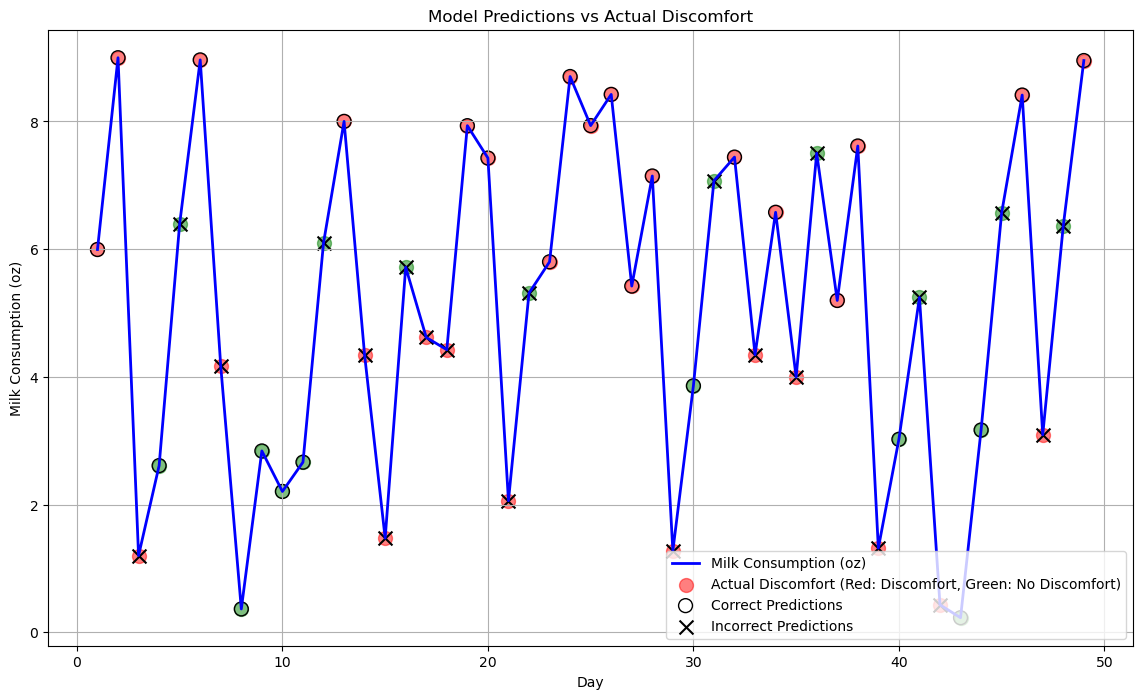

In [29]:
# Plotting
plt.figure(figsize=(14, 8))

# Plot the milk consumption over days
plt.plot(results_df['day'], results_df['milk_consumption'], label='Milk Consumption (oz)', color='blue', linewidth=2)

# Overlay the actual discomfort (red if actual discomfort, green if no discomfort)
for i, row in results_df.iterrows():
    color = 'red' if row['actual_discomfort'] == 1 else 'green'
    plt.scatter(row['day'], row['milk_consumption'], color=color, s=100, alpha=0.5, label='Actual Discomfort (Red: Discomfort, Green: No Discomfort)' if i == 0 else "")

# Overlay the correct predictions (empty circles)
correct_preds = results_df[results_df['correct']]
plt.scatter(correct_preds['day'], correct_preds['milk_consumption'], edgecolor='black', facecolor='none', s=100, marker='o', label='Correct Predictions')

# Overlay the incorrect predictions (black crosses)
incorrect_preds = results_df[~results_df['correct']]
plt.scatter(incorrect_preds['day'], incorrect_preds['milk_consumption'], color='black', s=100, marker='x', label='Incorrect Predictions')

# Ensure the legend has the appropriate labels
plt.title('Model Predictions vs Actual Discomfort')
plt.xlabel('Day')
plt.ylabel('Milk Consumption (oz)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()